<a href="https://colab.research.google.com/github/nussarafirn/aarhus-aqi/blob/main/aarhus_dmi_correlation_real_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the workbook that is used to train a linear regression model and find a correlation for the full dataset from DMI and the cruise schedules. 

## Import packages

In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing data

In [26]:
data = pd.read_json('/content/drive/MyDrive/aarhus/dataset/larger/dataset_x_label.json')
data.head()

0    1    2    3       4    5      6    7   8    9   10  11  12  13  14  \
0   0.0  3.1   49  1.5  1002.7  0.4    0.2  0.0  88  1.1   0   0   0   0   4   
1   0.2  2.1   60  1.8  1005.0  0.9   36.0  0.2  90  0.9   0   0   0   0   4   
2   5.8  1.9  330  2.0  1005.2  1.3   74.2  0.1  91  0.6   0   0   0   0   4   
3  28.2  1.9  329  2.3  1005.1  1.0  107.1  0.0  82  1.0   0   0   0   0   4   
4  12.1  1.8  327  2.4  1005.1  1.3   78.3  0.0  81  1.2   0   0   0   0   4   

   15  16  17          18  
0   1   1   1  395.745833  
1   1   1  10   22.395455  
2   1   1  11   30.000000  
3   1   1  12   47.000000  
4   1   1  13   56.333333

### Data fields:


```
      idx   : describtion
          0	m['bright_sunshine'],
          1	m['max_wind_speed_10min'],
          2	m['mean_wind_dir'],
          3	m['mean_temp'],
          4	m['mean_pressure'],
          5	m['min_temp'],
          6	m['mean_radiation'],
          7	m['acc_precip'],
          8	m['mean_cloud_cover'],
          9	m['mean_wind_speed'],
          10	len(m['ships']) if m['ship'] == 1 else 0,
          11	sum(s['Antal Pax'] for s in m['ships']) if m['ship'] == 1 else 0,
          12	sum(s['Antal crew'] for s in m['ships']) if m['ship'] == 1 else 0,
          13	sum(len(s['time_range']) for s in m['ships']) if m['ship'] == 1 else 0,
          14	datetime(*[int(s) for s in m["local_date"].split("-")]).weekday(),
          15	datetime.strptime(m['local_date'], '%Y-%m-%d').month,
          16	datetime.strptime(m['local_date'], '%Y-%m-%d').day,
          17	m['local_time']
```

In [27]:
data.shape

(12185, 19)

In [28]:
from google.colab import output
output.enable_custom_widget_manager()

In [29]:
# generate data stats
data.describe()

0             1             2             3             4   \
count  12185.000000  12185.000000  12185.000000  12185.000000  12185.000000   
mean      11.922372      5.555018    207.798687      7.677587   1014.476340   
std       21.266929      2.667158     92.614483      6.564467     11.649752   
min        0.000000      0.800000      0.000000    -15.000000    964.800000   
25%        0.000000      3.600000    136.000000      2.600000   1007.700000   
50%        0.000000      5.200000    235.000000      7.100000   1015.500000   
75%       16.500000      7.100000    281.000000     12.500000   1022.400000   
max      898.200000     22.800000    360.000000     28.500000   1050.900000   

                 5             6             7             8             9   \
count  12185.000000  12185.000000  12185.000000  12185.000000  12185.000000   
mean       6.514099    113.566139      0.134690     56.192039      3.492688   
std        6.569065    180.694555      1.522544     40.166911      1.885668   
min      -17.600000      0.000000      0.000000      0.000000      0.100000   
25%        1.500000      0.200000      0.000000      6.000000      2.100000   
50%        6.000000      7.400000      0.000000     77.000000      3.200000   
75%       11.300000    169.000000      0.000000     93.000000      4.600000   
max       26.300000   1778.400000    103.900000    100.000000     18.300000   

                 10            11            12            13            14  \
count  12185.000000  12185.000000  12185.000000  12185.000000  12185.000000   
mean       0.027493     72.371769     19.569471      0.297497      3.005252   
std        0.172319    479.055944    134.002986      1.860106      2.003724   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      1.000000   
50%        0.000000      0.000000      0.000000      0.000000      3.000000   
75%        0.000000      0.000000      0.000000      0.000000      5.000000   
max        2.000000   6463.000000   2286.000000     21.000000      6.000000   

                 15            16            17            18  
count  12185.000000  12185.000000  12185.000000  12185.000000  
mean       5.505375     15.503488     11.500780     14.156288  
std        3.424808      8.719258      6.922018     30.160760  
min        1.000000      1.000000      0.000000      0.000000  
25%        3.000000      8.000000      6.000000      3.240833  
50%        5.000000     15.000000     12.000000      6.615833  
75%        8.000000     23.000000     17.000000     15.010909  
max       12.000000     31.000000     23.000000   1413.408333

In [30]:
# overall info including type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12185 entries, 0 to 12184
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12185 non-null  float64
 1   1       12185 non-null  float64
 2   2       12185 non-null  int64  
 3   3       12185 non-null  float64
 4   4       12185 non-null  float64
 5   5       12185 non-null  float64
 6   6       12185 non-null  float64
 7   7       12185 non-null  float64
 8   8       12185 non-null  int64  
 9   9       12185 non-null  float64
 10  10      12185 non-null  int64  
 11  11      12185 non-null  int64  
 12  12      12185 non-null  int64  
 13  13      12185 non-null  int64  
 14  14      12185 non-null  int64  
 15  15      12185 non-null  int64  
 16  16      12185 non-null  int64  
 17  17      12185 non-null  int64  
 18  18      12185 non-null  float64
dtypes: float64(9), int64(10)
memory usage: 1.8 MB


## Data Pre-processing

In [31]:
# check null values
data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

In [32]:
# deleting missing values
data = data.dropna()
data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

## Predictions

In [34]:
# excluding labels
features = data
features = features.drop(features.columns[18], axis=1)
features

0     1    2     3       4     5      6    7   8    9   10    11  \
0       0.0   3.1   49   1.5  1002.7   0.4    0.2  0.0  88  1.1   0     0   
1       0.2   2.1   60   1.8  1005.0   0.9   36.0  0.2  90  0.9   0     0   
2       5.8   1.9  330   2.0  1005.2   1.3   74.2  0.1  91  0.6   0     0   
3      28.2   1.9  329   2.3  1005.1   1.0  107.1  0.0  82  1.0   0     0   
4      12.1   1.8  327   2.4  1005.1   1.3   78.3  0.0  81  1.2   0     0   
...     ...   ...  ...   ...     ...   ...    ...  ...  ..  ...  ..   ...   
12180  48.7   3.9  151  12.2  1011.2  10.3  274.1  0.0  39  2.6   0     0   
12181  34.1   5.4  149  13.6  1010.7  12.4  317.2  0.0  82  3.8   1  3475   
12182  50.4   6.0  149  14.6  1010.3  13.7  522.0  0.0  17  4.7   1  3475   
12183   0.0  10.1  189  12.9  1001.1  10.1    0.1  0.0  11  5.8   0     0   
12184   0.0   9.0  110  12.1  1000.2  11.5    0.1  0.0  19  5.6   0     0   

         12  13  14  15  16  17  
0         0   0   4   1   1   1  
1         0   0   4   1   1  10  
2         0   0   4   1   1  11  
3         0   0   4   1   1  12  
4         0   0   4   1   1  13  
...     ...  ..  ..  ..  ..  ..  
12180     0   0   0   5  23   7  
12181  1000  11   0   5  23   8  
12182  1000  11   0   5  23   9  
12183     0   0   1   5  24   0  
12184     0   0   1   5  24   1  

[12185 rows x 18 columns]

In [35]:
labels = pd.read_json('/content/drive/MyDrive/aarhus/dataset/larger/dataset_y_r.json')
labels.head()

0
0  395.745833
1   22.395455
2   30.000000
3   47.000000
4   56.333333

In [36]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = .3)

In [37]:
print(x_test.shape, y_test.shape)

(3656, 18) (3656, 1)


In [38]:
print(x_train.shape, y_train.shape)

(8529, 18) (8529, 1)


In [39]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [40]:
lr.score(x_test, y_test)

0.07646816508844778

In [41]:
y_pred = lr.predict(x_test)
y_pred

array([[ 8.61303542],
       [ 4.51953062],
       [10.82065898],
       ...,
       [20.88549532],
       [21.1120604 ],
       [15.47395772]])

In [42]:
# the mean square error
print('Mean square error (MSE): %.2f ' % mean_squared_error(y_test, y_pred))

Mean square error (MSE): 461.74 




## Data Exploration



In [43]:
!pip install pandas_visual_analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from pandas_visual_analysis import VisualAnalysis
VisualAnalysis(data)

In [45]:
from google.colab import output
output.enable_custom_widget_manager()

In [46]:
data.corr()

0         1         2         3         4         5         6   \
0   1.000000 -0.016649 -0.017372  0.287751  0.191859  0.262935  0.745038   
1  -0.016649  1.000000  0.117284 -0.035026 -0.366267 -0.009251  0.000676   
2  -0.017372  0.117284  1.000000 -0.008244 -0.041793 -0.008464 -0.036001   
3   0.287751 -0.035026 -0.008244  1.000000  0.000639  0.991933  0.467470   
4   0.191859 -0.366267 -0.041793  0.000639  1.000000 -0.022389  0.126227   
5   0.262935 -0.009251 -0.008464  0.991933 -0.022389  1.000000  0.452702   
6   0.745038  0.000676 -0.036001  0.467470  0.126227  0.452702  1.000000   
7  -0.045326  0.066875 -0.016253  0.004649 -0.073846 -0.001132 -0.040732   
8  -0.433326  0.196154 -0.073039 -0.050762 -0.319849 -0.007133 -0.267106   
9   0.041502  0.927867  0.063096  0.030544 -0.335547  0.065433  0.112045   
10  0.097757 -0.005041 -0.002142  0.194184  0.017381  0.194872  0.188845   
11  0.092865  0.002540 -0.000799  0.188480  0.017556  0.189055  0.181773   
12  0.095821  0.005012  0.004355  0.176578  0.019294  0.177232  0.185242   
13  0.097545 -0.004481 -0.002895  0.196059  0.016252  0.196716  0.188479   
14  0.010953  0.039845 -0.001840 -0.010305  0.023586 -0.008804  0.006737   
15 -0.046516 -0.124224 -0.027054  0.372785 -0.063136  0.370507 -0.013716   
16  0.020754 -0.013989  0.063048  0.077546  0.042407  0.078219  0.012561   
17  0.083324  0.013025 -0.020834  0.130403  0.000728  0.148457  0.102388   
18 -0.065235 -0.110517 -0.050174 -0.107932  0.014144 -0.109412 -0.100072   

          7         8         9         10        11        12        13  \
0  -0.045326 -0.433326  0.041502  0.097757  0.092865  0.095821  0.097545   
1   0.066875  0.196154  0.927867 -0.005041  0.002540  0.005012 -0.004481   
2  -0.016253 -0.073039  0.063096 -0.002142 -0.000799  0.004355 -0.002895   
3   0.004649 -0.050762  0.030544  0.194184  0.188480  0.176578  0.196059   
4  -0.073846 -0.319849 -0.335547  0.017381  0.017556  0.019294  0.016252   
5  -0.001132 -0.007133  0.065433  0.194872  0.189055  0.177232  0.196716   
6  -0.040732 -0.267106  0.112045  0.188845  0.181773  0.185242  0.188479   
7   1.000000  0.064585  0.027805 -0.005544 -0.004252 -0.005151 -0.005487   
8   0.064585  1.000000  0.212600 -0.015763 -0.011080 -0.013192 -0.015894   
9   0.027805  0.212600  1.000000  0.026054  0.031673  0.033281  0.026610   
10 -0.005544 -0.015763  0.026054  1.000000  0.958028  0.953019  0.999483   
11 -0.004252 -0.011080  0.031673  0.958028  1.000000  0.982163  0.959338   
12 -0.005151 -0.013192  0.033281  0.953019  0.982163  1.000000  0.950462   
13 -0.005487 -0.015894  0.026610  0.999483  0.959338  0.950462  1.000000   
14 -0.008260  0.002786  0.034792  0.037377  0.028722  0.036934  0.036774   
15  0.017695  0.059829 -0.122116  0.078812  0.068156  0.061717  0.079157   
16 -0.035439 -0.050290  0.001276  0.031046  0.034579  0.033314  0.030676   
17 -0.066686 -0.051018  0.071610  0.057265  0.055766  0.052275  0.057782   
18  0.002564  0.088534 -0.105774 -0.017877 -0.015077 -0.018163 -0.018003   

          14        15        16        17        18  
0   0.010953 -0.046516  0.020754  0.083324 -0.065235  
1   0.039845 -0.124224 -0.013989  0.013025 -0.110517  
2  -0.001840 -0.027054  0.063048 -0.020834 -0.050174  
3  -0.010305  0.372785  0.077546  0.130403 -0.107932  
4   0.023586 -0.063136  0.042407  0.000728  0.014144  
5  -0.008804  0.370507  0.078219  0.148457 -0.109412  
6   0.006737 -0.013716  0.012561  0.102388 -0.100072  
7  -0.008260  0.017695 -0.035439 -0.066686  0.002564  
8   0.002786  0.059829 -0.050290 -0.051018  0.088534  
9   0.034792 -0.122116  0.001276  0.071610 -0.105774  
10  0.037377  0.078812  0.031046  0.057265 -0.017877  
11  0.028722  0.068156  0.034579  0.055766 -0.015077  
12  0.036934  0.061717  0.033314  0.052275 -0.018163  
13  0.036774  0.079157  0.030676  0.057782 -0.018003  
14  1.000000 -0.007372  0.012993  0.000733 -0.020782  
15 -0.007372  1.000000  0.015478  0.000246 -0.001611  
16  0.012993  0.015478  1.000000 

### Data fields:


```
      idx   : describtion
          0	m['bright_sunshine'],
          1	m['max_wind_speed_10min'],
          2	m['mean_wind_dir'],
          3	m['mean_temp'],
          4	m['mean_pressure'],
          5	m['min_temp'],
          6	m['mean_radiation'],
          7	m['acc_precip'],
          8	m['mean_cloud_cover'],
          9	m['mean_wind_speed'],
          10	len(m['ships']) if m['ship'] == 1 else 0,
          11	sum(s['Antal Pax'] for s in m['ships']) if m['ship'] == 1 else 0,
          12	sum(s['Antal crew'] for s in m['ships']) if m['ship'] == 1 else 0,
          13	sum(len(s['time_range']) for s in m['ships']) if m['ship'] == 1 else 0,
          14	datetime(*[int(s) for s in m["local_date"].split("-")]).weekday(),
          15	datetime.strptime(m['local_date'], '%Y-%m-%d').month,
          16	datetime.strptime(m['local_date'], '%Y-%m-%d').day,
          17	m['local_time']
```

In [47]:
import seaborn as sns

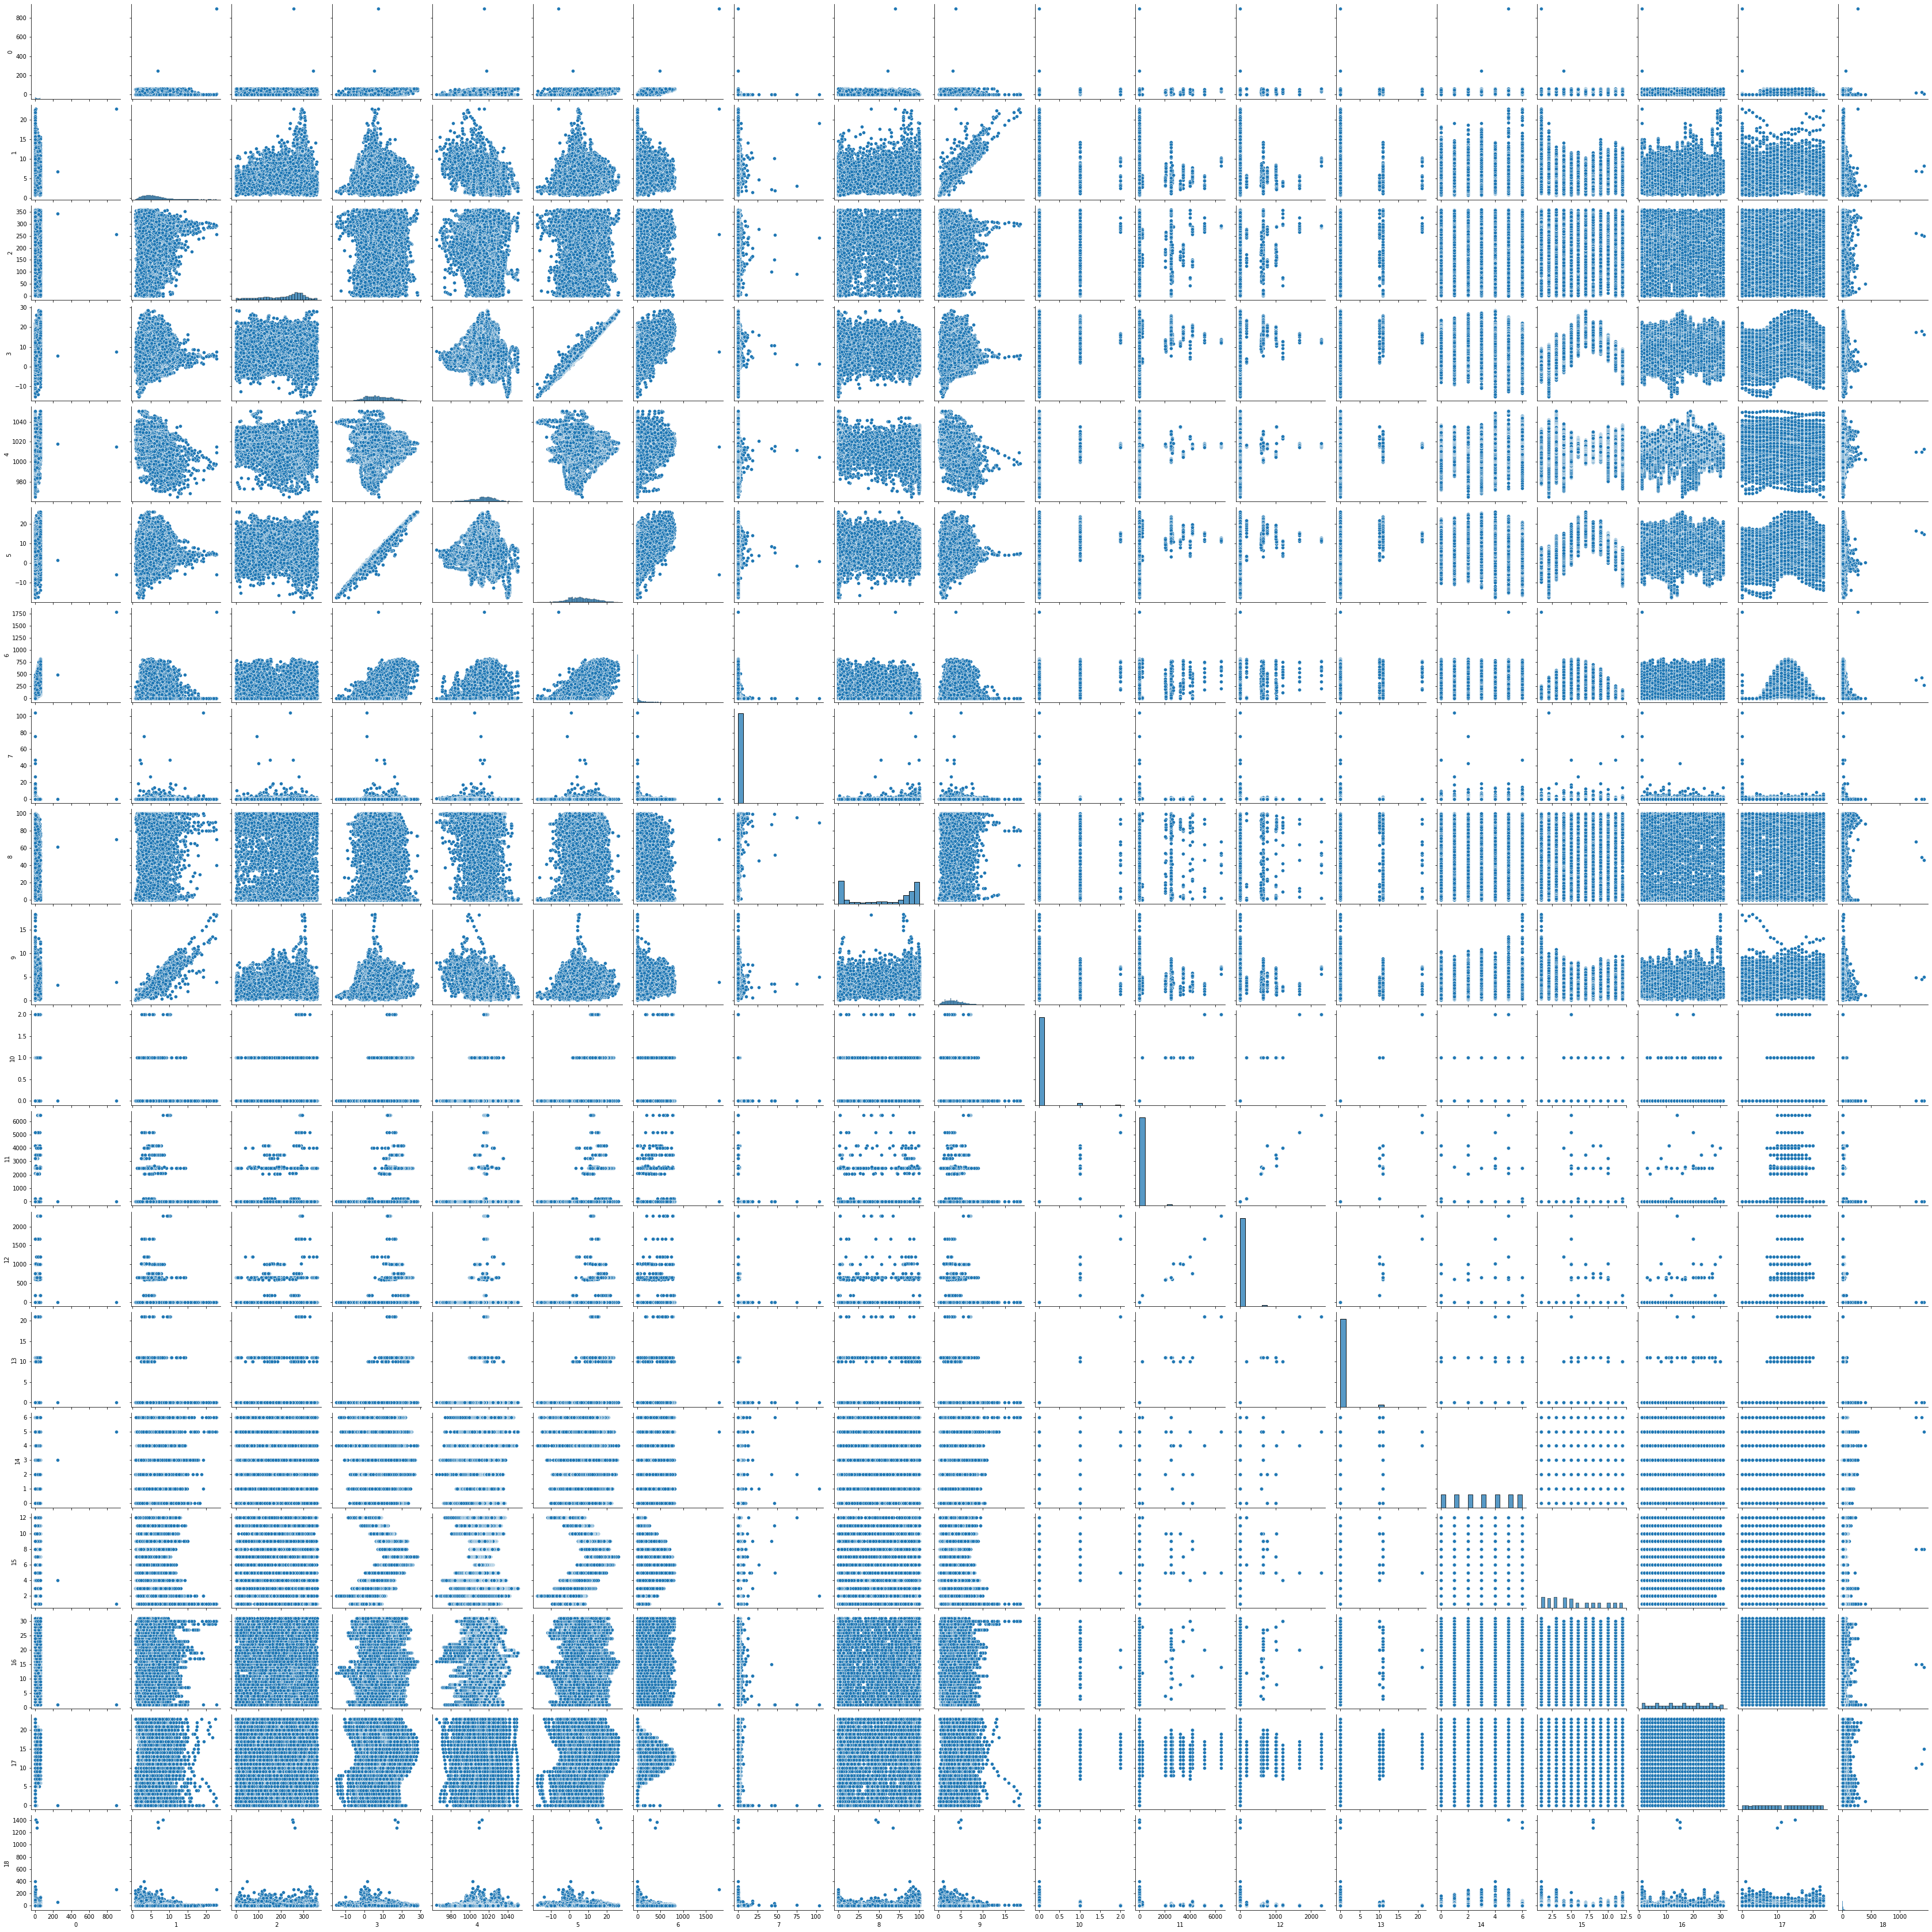

In [48]:
sns.pairplot(data)

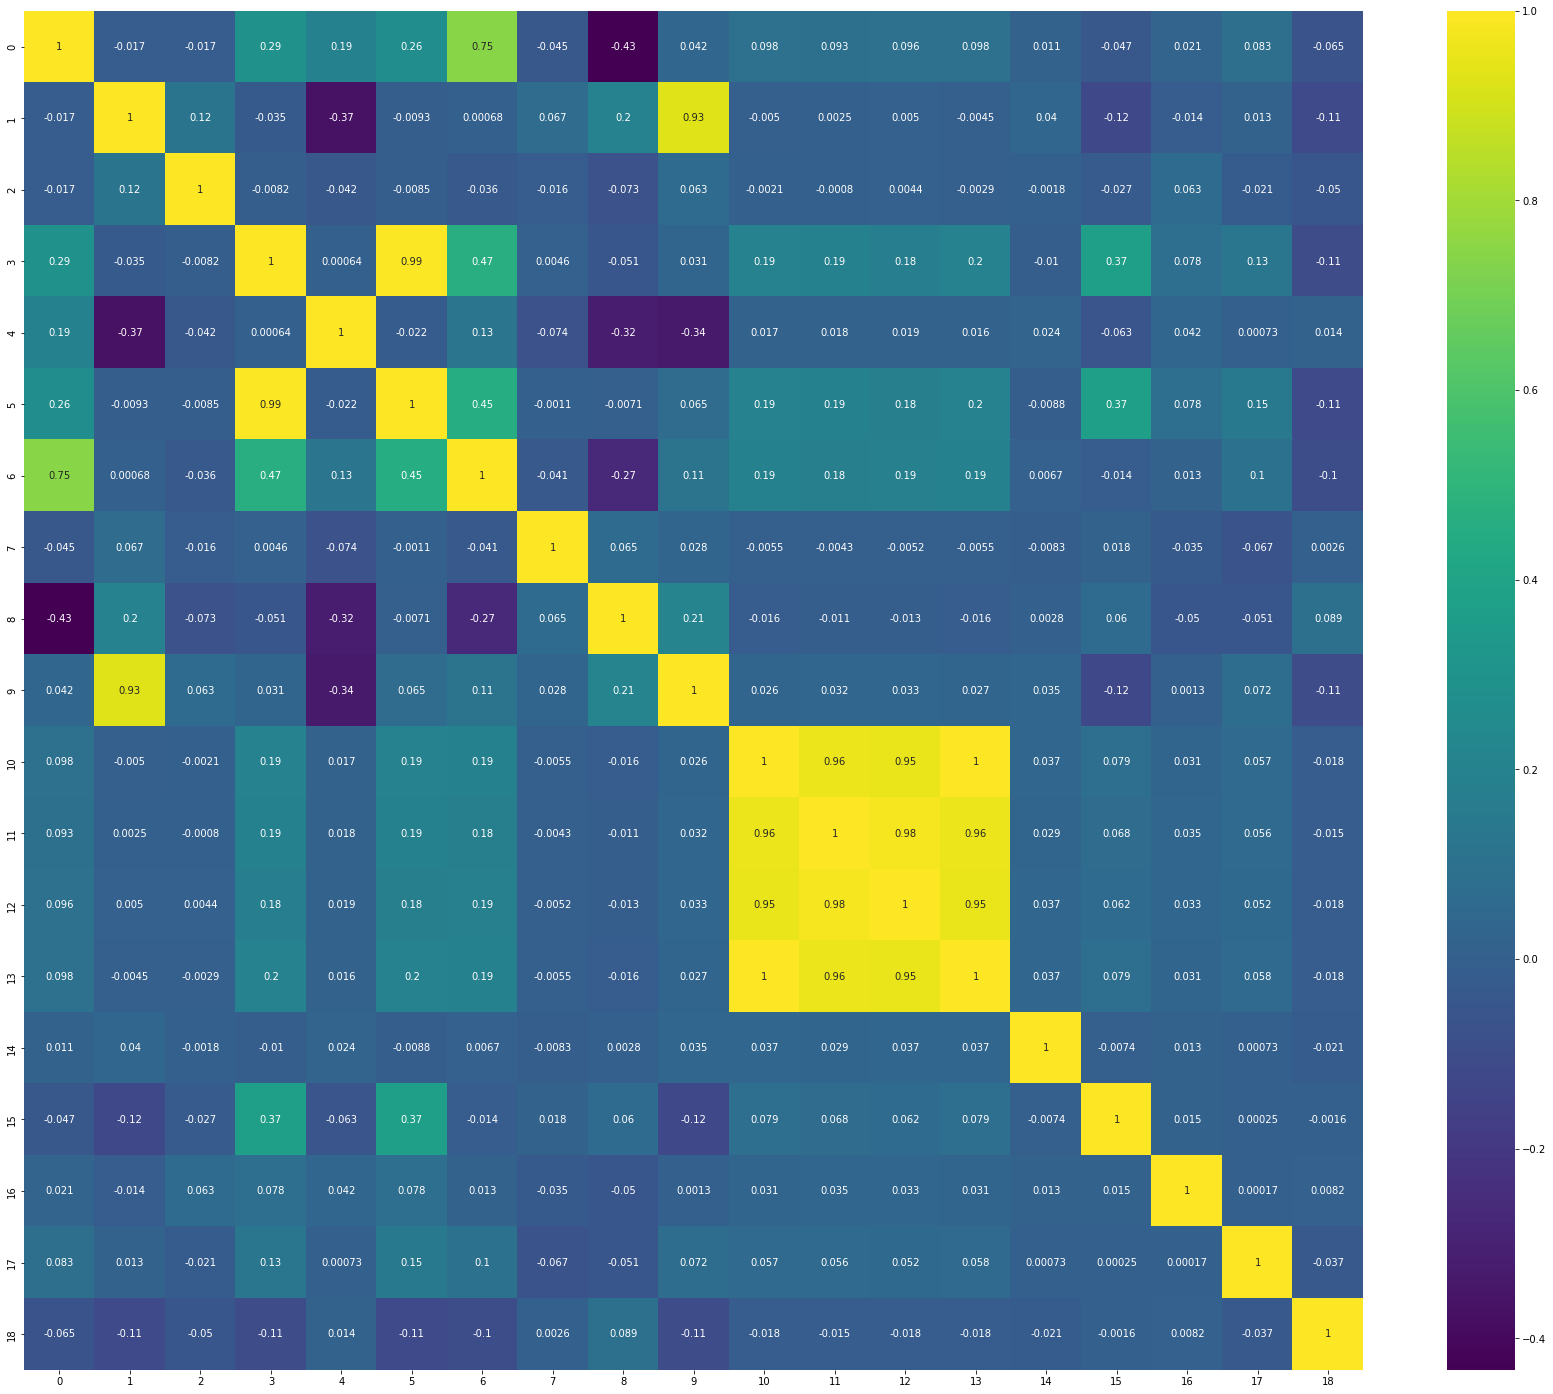

In [49]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,25))

# plot heatmap
heatmap = sns.heatmap(data[top_corr_features].corr(), annot = True, cmap='viridis') 